In [3]:
pip install pycocotools matplotlib opencv-python


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install albumentations==1.4.4


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


loading annotations into memory...
Done (t=1.10s)
creating index...
index created!


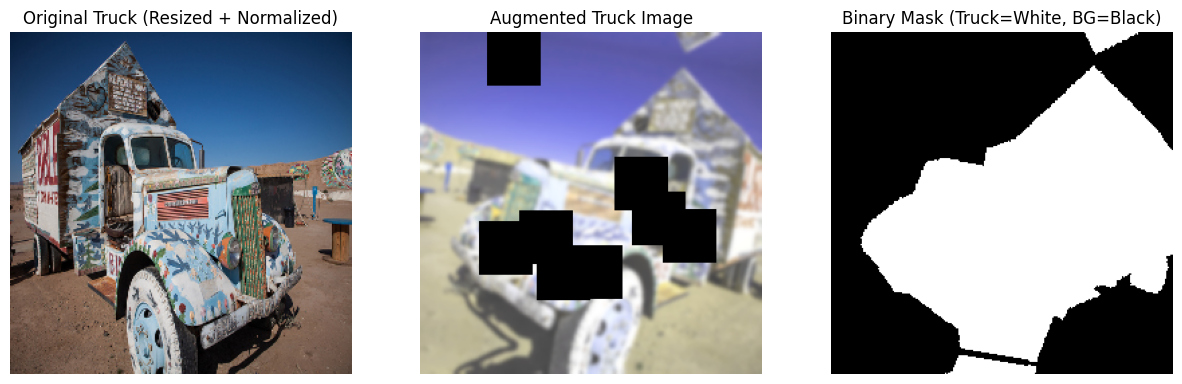

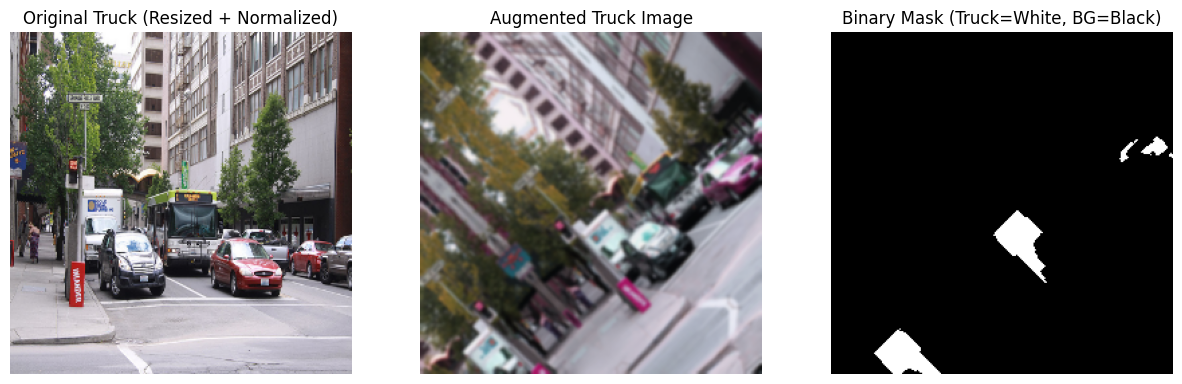

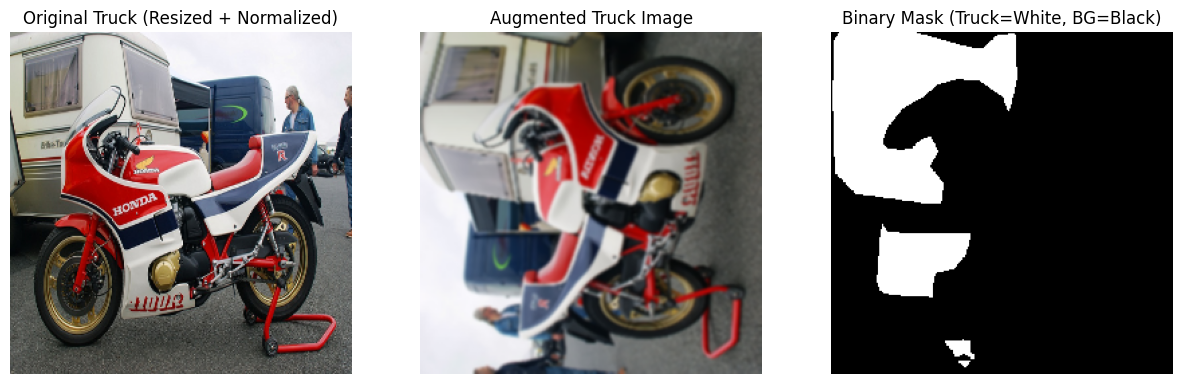

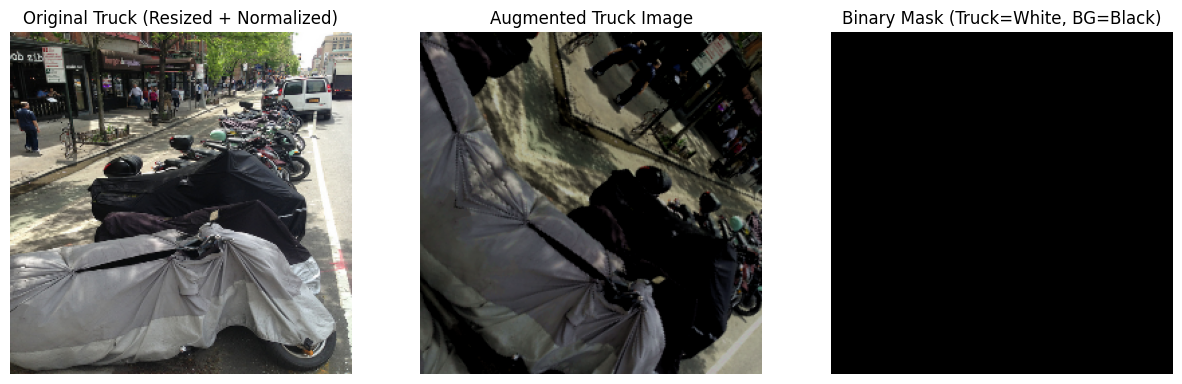

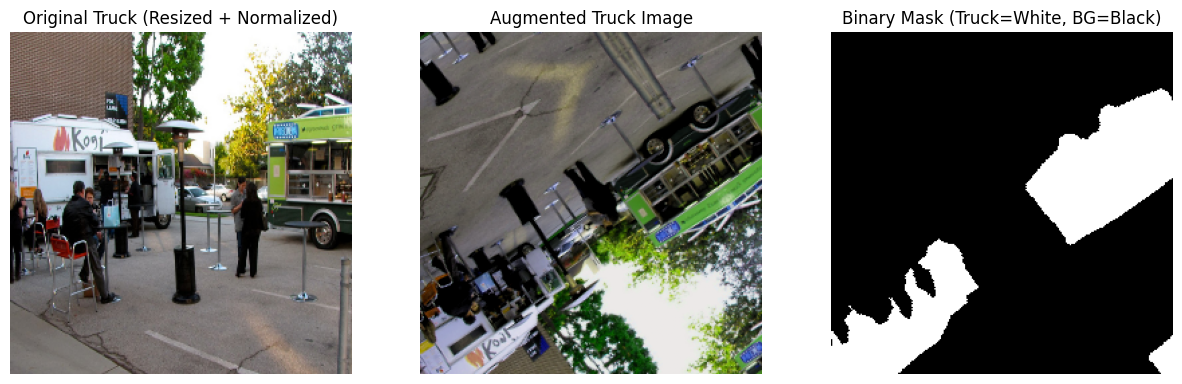

In [17]:
import os, random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pycocotools.coco import COCO
import albumentations as A

# ============================
# Paths (update if needed)
# ============================
imgDir  = r"C:\Users\KIIT0001\Desktop\infosys aiml\val2017\val2017"
annFile = r"C:\Users\KIIT0001\Desktop\infosys aiml\annotations_trainval2017\annotations\instances_val2017.json"

# Load COCO
coco = COCO(annFile)

# Get category ID for "truck"
truck_catId = coco.getCatIds(catNms=["truck"])[0]

# Get only images containing trucks
truck_imgIds = coco.getImgIds(catIds=[truck_catId])
random.shuffle(truck_imgIds)

# Select a few random truck images
sample_imgIds = truck_imgIds[:5]

# ============================
# Augmentation pipeline
# ============================
transform = A.Compose([
    A.Resize(255, 255),
    A.RandomRotate90(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=60, p=0.7),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.4),
    A.RandomGamma(p=0.4),
    A.CoarseDropout(max_holes=8, max_height=40, max_width=40, p=0.3)
])

# ============================
# Process truck images
# ============================
for idx, imgId in enumerate(sample_imgIds, 1):
    imgInfo = coco.loadImgs(imgId)[0]

    # Load image
    imgPath = os.path.join(imgDir, imgInfo['file_name'])
    image = cv2.cvtColor(cv2.imread(imgPath), cv2.COLOR_BGR2RGB)

    # Load truck annotations
    annIds = coco.getAnnIds(imgIds=imgInfo['id'], catIds=[truck_catId])
    anns = coco.loadAnns(annIds)

    # Build binary mask (truck=1, background=0)
    mask = np.zeros((imgInfo['height'], imgInfo['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann).astype(np.uint8))

    # Resize + normalize image
    image_resized = cv2.resize(image, (255, 255)).astype(np.float32) / 255.0
    mask_resized = cv2.resize(mask, (255, 255), interpolation=cv2.INTER_NEAREST)

    # Binary mask (truck=white, background=black)
    binary_mask = (mask_resized * 255).astype(np.uint8)

    # ============================
    # Apply augmentation
    # ============================
    augmented = transform(image=image, mask=mask)
    aug_img, aug_mask = augmented["image"], augmented["mask"]

    aug_img_norm = aug_img.astype(np.float32) / 255.0
    aug_binary_mask = (aug_mask * 255).astype(np.uint8)

    # ============================
    # Show results
    # ============================
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image_resized)
    ax[0].set_title("Original Truck (Resized + Normalized)")
    ax[0].axis("off")

    ax[1].imshow(aug_img_norm)
    ax[1].set_title("Augmented Truck Image")
    ax[1].axis("off")

    ax[2].imshow(aug_binary_mask, cmap="gray")
    ax[2].set_title("Binary Mask (Truck=White, BG=Black)")
    ax[2].axis("off")

    plt.show()
